In [1]:
import numpy as np
import pandas as pd
train_df=pd.read_csv('./happiness_train_abbr.csv',index_col=0)
test_df=pd.read_csv('./happiness_test_abbr.csv',index_col=0)
import  seaborn as sns
%matplotlib inline
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [2]:
train_df.head()

,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,...,family_income,family_m,family_status,house,car,marital,status_peer,status_3_before,view,inc_ability
id,,,,,,,,,,,,,,,,,,,,,
1,4,1,12,32,59,2015/8/4 14:18,1,1959,1,1,...,60000.0,2,2,1,2,3,3,2,4,3
2,4,2,18,52,85,2015/7/21 15:04,1,1992,1,1,...,40000.0,3,4,1,2,1,1,1,4,2
3,4,2,29,83,126,2015/7/21 13:24,2,1967,1,0,...,8000.0,3,3,1,2,3,2,1,4,2
4,5,2,10,28,51,2015/7/25 17:33,2,1943,1,1,...,12000.0,3,3,1,1,7,2,1,3,2
5,4,1,7,18,36,2015/8/10 9:50,2,1994,1,1,...,-2.0,4,3,1,1,1,3,2,3,-8


In [3]:
happiness=train_df.happiness.value_counts()
happiness.values

array([4818, 1410, 1159,  497,  104,   12], dtype=int64)

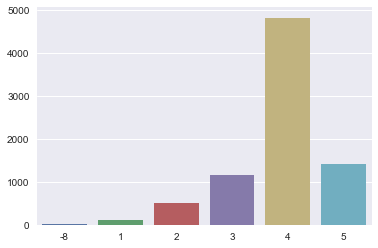

In [4]:
sns.barplot(x=happiness.index,y=happiness.values)#样本不太均衡

In [5]:
# train_df.info()

In [6]:
drop_feature=['survey_time']

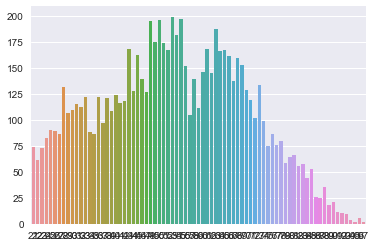

In [7]:
age=2018-train_df.birth
age_count=age.value_counts()
sns.barplot(age_count.index,age_count.values,)#年龄分布

In [8]:
# sns.barplot(x=age.index,age.values)
age.values

array([59, 26, 51, ..., 51, 40, 27], dtype=int64)

In [9]:
y_train=train_df.happiness
#合并测试和训练集，
train_df=train_df.drop(['happiness'],axis=1)
all_data=pd.concat([train_df,test_df])
# all_data



In [10]:
#删除survey_time列，因为提交时间跟幸福感没有多大关系
all_data=all_data.drop(['survey_time'],axis=1)


In [11]:
#填充缺失值
from sklearn.preprocessing import Imputer
im = Imputer(strategy="median",axis=1)#中位数填充
filled_nan_data = im.fit_transform(all_data)
all_data=pd.DataFrame(filled_nan_data,index=range(1,len(all_data)+1),columns=all_data.columns)
# all_data.info()

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
X_train =all_data.loc[train_df.index]
X_val=all_data.loc[test_df.index]
# X_test

In [13]:
#首先自定义得分函数
def my_metric(y_pred,y_true):
    label=y_true.get_label()
#     print(y_pred.shape)#预测出来的是概率值，每行六个概率，
    arr=np.argmax(y_pred,axis=1)
#     print(arr)
#     print(label)
    return 'my_metric',np.abs(np.mean((label-arr)**2))

In [14]:
X=X_train
y=y_train
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=42)

In [15]:
def my_loss(y_pred,y_true):
#     print(y_pred)
#     print(y_true)
#     print(np.abs(np.mean((y_pred-y_true)**2)))
    return np.abs(np.mean((y_pred-y_true)**2))

In [27]:
#调参xgboost
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV 
score = make_scorer(my_loss, greater_is_better=False)
cv_params = {
#             'n_estimators': [50,60, 70,80,90,100, 110,120, 130],
#             'learning_rate': [0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03],
#             'subsample':[ 0.1 * i for i in range(6,9)],
#             'colsample_bytree':[ 0.1 * i for i in range(6,9)],
#             'gamma':[ 0.1 * i for i in range(0,5)],
            'max_depth': list(range(4,9)), 
            'min_child_weight': list((1,3,6))
}
# cv_params = {'n_estimators': [100,150]}
other_params = { 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,'random_state':42,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1,'objective':'multi:softmax','n_jobs':-1}

model = XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=score, cv=5, verbose=3)
optimized_GBM.fit(X=X_train,y= y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] max_depth=4, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... max_depth=4, min_child_weight=1, score=-0.76, total=   0.9s
[CV] max_depth=4, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  max_depth=4, min_child_weight=1, score=-0.8732525629077353, total=   1.0s
[CV] max_depth=4, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=4, min_child_weight=1, score=-0.6984126984126984, total=   0.9s
[CV] max_depth=4, min_child_weight=1 .................................
[CV]  max_depth=4, min_child_weight=1, score=-0.7320261437908496, total=   1.0s
[CV] max_depth=4, min_child_weight=1 .................................
[CV]  max_depth=4, min_child_weight=1, score=-0.6654205607476635, total=   1.0s
[CV] max_depth=4, min_child_weight=3 .................................
[CV]  max_depth=4, min_child_weight=3, score=-0.7525581395348837, total=   0.9s
[CV] max_depth=4, min_child_weight=3 .................................
[CV]  max_depth=4, min_child_weight=3, score=-0.8630009319664492, total=   0.9s
[CV] max_depth=4, min_child_weight=3 .................................
[CV]  max_depth=4, min_child_weight=3, score=-0.6853408029878618, total=   0.9s
[CV] max_depth=4, min_child_weight=3 .................................
[CV]  max_depth=4, min_child_weight=3, score=-0.7245564892623716, total=   0.9s
[CV] max_depth

[CV]  max_depth=7, min_child_weight=6, score=-0.6872082166199813, total=   1.3s
[CV] max_depth=7, min_child_weight=6 .................................
[CV]  max_depth=7, min_child_weight=6, score=-0.7329598506069094, total=   1.3s
[CV] max_depth=7, min_child_weight=6 .................................
[CV]  max_depth=7, min_child_weight=6, score=-0.6915887850467289, total=   1.3s
[CV] max_depth=8, min_child_weight=1 .................................
[CV]  max_depth=8, min_child_weight=1, score=-0.8018604651162791, total=   1.6s
[CV] max_depth=8, min_child_weight=1 .................................
[CV]  max_depth=8, min_child_weight=1, score=-0.8881640260950606, total=   1.5s
[CV] max_depth=8, min_child_weight=1 .................................
[CV]  max_depth=8, min_child_weight=1, score=-0.6862745098039216, total=   1.5s
[CV] max_depth=8, min_child_weight=1 .................................
[CV]  max_depth=8, min_child_weight=1, score=-0.7376283846872083, total=   1.5s
[CV] max_depth

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softmax', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [4, 5, 6, 7, 8], 'min_child_weight': [1, 3, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(my_loss, greater_is_better=False), verbose=3)

In [28]:
# evalute_result = optimized_GBM.cv_results_ 
# print('每轮迭代运行结果:{0}'.format(evalute_result))
print(optimized_GBM.best_estimator_)
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=0, silent=True, subsample=0.8)
参数的最佳取值：{'max_depth': 5, 'min_child_weight': 1}
最佳模型得分:-0.7352611940298508


In [97]:
# 完整可调
model=XGBClassifier(objective='multi:softmax')
model.fit(X_train,y_train,early_stopping_rounds=10,eval_metric=my_metric,eval_set=[(X_test,y_test)],verbose=True)
y_pred=model.predict(X_test)

[0]	validation_0-merror:0.395076	validation_0-my_metric:0.682197
Multiple eval metrics have been passed: 'validation_0-my_metric' will be used for early stopping.

Will train until validation_0-my_metric hasn't improved in 10 rounds.
[1]	validation_0-merror:0.396212	validation_0-my_metric:0.690152
[2]	validation_0-merror:0.395833	validation_0-my_metric:0.682576
[3]	validation_0-merror:0.39697	validation_0-my_metric:0.694318
[4]	validation_0-merror:0.396591	validation_0-my_metric:0.689394
[5]	validation_0-merror:0.396591	validation_0-my_metric:0.695455
[6]	validation_0-merror:0.395833	validation_0-my_metric:0.682197
[7]	validation_0-merror:0.395076	validation_0-my_metric:0.688258
[8]	validation_0-merror:0.395076	validation_0-my_metric:0.681061
[9]	validation_0-merror:0.395833	validation_0-my_metric:0.6875
[10]	validation_0-merror:0.396212	validation_0-my_metric:0.685985
[11]	validation_0-merror:0.396212	validation_0-my_metric:0.684848
[12]	validation_0-merror:0.395833	validation_0-my_me

In [98]:
np.mean((y_test-y_pred)**2)

0.9026515151515152

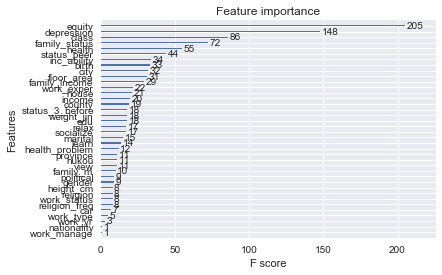

In [107]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
plot_importance(model)
plt.figure(figsize=(10,20))
plt.show()